# Meta-VQE algorithm (demo) <img src="img/ML_logo.png" width="20%" align="right">
_______________________________________________________

_Authors:_ Alba Cervera-Lierta, Jakob S. Kottmann, Alán Aspuru-Guzik.

This notebook presents a demo code to reproduce the results of the article "The Meta-Variational Quantum Eigensolver (Meta-VQE): Learning energy profiles of parameterized Hamiltonians for quantum simulation" (http://arxiv.org/abs/2009.13545).

This demo simulates a meta-VQE for the 1D XXZ model with external field. It also shows the comparison with a standard VQE, opt-meta-VQE, GA-VQE and opt-GA-VQE algorithms detailed in the main article. 

For computational reasons, the notebook is set to simulate a $n=4$ spin chain and a meta-VQE with $2$ encoding layer and $1$ processing layers. Results shown in the main article can be obtained by adjusting the number of qubits and layers. Article results can be found in "data" (link) folder in this repository.

The code is written using [_Tequila_](https://github.com/aspuru-guzik-group/tequila) language and [_qulacs_](https://github.com/qulacs/qulacs) simulator as a default backend.

__Table of contents:__
1. [Model and PQC ansatz](#Model-and-PQC-ansatz)
    1. [Hamiltonian: XXZ with external field](#Hamiltonian:-XXZ-with-external-field)
    1. [Parametrized Quantum Circuit](#Parametrized-Quantum-Circuit)
1. [Main code: meta-VQE algorithm](#Main-code:-meta-VQE-algorithm)
    1. [Meta-VQE](#Meta-VQE)
        1. [Training](#Training)
        1. [Test](#Test)
    1. [Comparison with other algorithms](#Comparison-with-other-algorithms)
        1. [Standard VQE](#Standard-VQE)
        1. [Globally-averaged VQE (GA-VQE)](#Globally-averaged-VQE-(GA-VQE))
        1. [VQE with meta-VQE initialization (opt-meta-VQE)](#VQE-with-meta-VQE-initialization-(opt-meta-VQE))
        1. [VQE with GA-VQE initialization (opt-GA-VQE)](#VQE-with-GA-VQE-initialization-(opt-GA-VQE))
    1. [Plots](#Plots)

In [1]:
# Import all we need
# tested with tq git revision: ab252adc4090465ff47f182de32d69b84d7fc13f
import tequila as tq
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import time

In [2]:
# Seed generator from alphabetic string
def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

seeds = ['matterlab', 'alba', 'jakob', 'alan']

s = 0 # default seed, used in the main article results
random.seed(seed_gen(seeds[s])) 

## Model and PQC ansatz

First, we will define the Hamiltonian and circuit ansatz used in this work. These functions can be easily modified to accomodate other hamiltonians or ansatzes.

### Hamiltonian: XXZ with external field

The spin Hamiltonian used is the 1D antiferromagnetic XXZ spin chain with external field $\lambda$ and periodic boundary conditions:
$$ \mathcal{H}=\sum_{i=1}^{n}\sigma_{i}^{x}\sigma_{i+1}^{x}+\sigma_{i}^{y}\sigma_{i+1}^{y}+\Delta\sigma_{i}^{z}\sigma_{i+1}^{z} + \lambda \sum_{i=1}^{n}\sigma_{i}^{z}.$$
To check the accuracy of the results obtained, we also compute the exact ground state energy of this Hamiltonian by diagonalizing it; we called that function `exact`.

In [3]:
def HXXZ(num_qubits,delta,lam):
    # PBC
    ham = tq.paulis.X(num_qubits-1)*tq.paulis.X(0) 
    ham += tq.paulis.Y(num_qubits-1)*tq.paulis.Y(0) 
    ham += delta*tq.paulis.Z(num_qubits-1)*tq.paulis.Z(0)
    ham += lam*tq.paulis.Z(num_qubits-1)
    for i in range(num_qubits-1):
        ham += tq.paulis.X(i)*tq.paulis.X(i+1)
        ham += tq.paulis.Y(i)*tq.paulis.Y(i+1)
        ham += delta*tq.paulis.Z(i)*tq.paulis.Z(i+1)
        ham += lam*tq.paulis.Z(i)
    return(ham)
def exact(num_qubits,delta,lam):
    ham_matrix = HXXZ(num_qubits,delta,lam).to_matrix()
    energ = np.linalg.eigvals(ham_matrix)
    return(min(energ))

### Parametrized Quantum Circuit

The meta-VQE algorithm needs a Parameterized Quantum Circuit (PQC) both for the encoding and processsing parts. We use a unique ansatz for both of them, where the parameters appear in the single-qubit rotational gates. The ansatz is divided in layers, each of them including single-qubit gates on each qubit plus CNOT gates between neighbouring pairs. 

First, we define the general single-qubit unitary gater `Ugen`,
$$ U_{gen} = R_{z}(\phi)R_{y}(\theta)R_{z}(\varphi). $$

The `PQC` depends on the number of qubits, layers, Hamiltonian argument and the optimization variable name. If the argument is zero (which will be the case for the processing layers, where there is no encoding), then it only uses `Ugen` gates with two optimization angles. On the contrary, if the arguments are different from zero (corresponding to the encoding layers), the `Ugen` gate angles will be defined as
$$ R_{z}(w_{il}^{(1)}\Delta + \phi_{il}^{(1)}) R_{y}(w_{il}^{(2)}\Delta + \phi_{il}^{(2)}), $$
where $i$ and $l$ correspond to the qubit and layer respectively.
Then, `PQC` will output a quantum circuit with $4L$ parameters for $L$ encoding layers, and $2L$ parameters for $L$ processing layers.

In [4]:
# General 1-qubit gate
# q0 = target qubit
def Ugen(th, phi, lam, q0):
    ugate = tq.gates.Rz(target=q0, angle=phi) + tq.gates.Ry(target=q0, angle=th) + tq.gates.Rz(target=q0, angle=lam)
    return ugate

def PQC(num_qubits, layers, arg, var_name):   
    U = tq.QCircuit()
    arg_tmp = [arg, arg]
        
    for l in range(layers):
        # Layer single-qubit gates
        for q in range(num_qubits):
            theta = tq.Variable(name="{}_{}{}".format(var_name, l, q))
            phi = tq.Variable(name="{}2_{}{}".format(var_name, l, q))
            if arg_tmp[0] == 0 and arg_tmp[1] == 0:
                U += Ugen(theta, phi, 0, q)  # for no encoding, reduce the total number of variables
            else:
                wth = tq.Variable(name="{}w_{}{}".format(var_name, l, q))
                wph = tq.Variable(name="{}2w_{}{}".format(var_name, l, q))
                U += Ugen(wth * arg_tmp[0] + theta, wph * arg_tmp[1] + phi, 0, q)
        # Layer alternating CNOTs
        ent0 = np.mod(l, 2)
        for ent in range(ent0, num_qubits - 1, 2):
            U += tq.gates.CNOT(control=ent, target=ent + 1)
    return (U)

## Main code: meta-VQE algorithm

First, we define the main characteristics of the meta-VQE algorithm and the tests that we would like to run to compare its performace.

In [5]:
# PQC ansatz: same for encoding and processing layers
ans_enc = PQC # ansatz variational circuit
ans_var = PQC # ansatz encoding

n_qub = 10 # qubits
n_lay = [2,2] # layers [encoding, processing]

# Hamiltonian argument limits
arg_max = -1.1
arg_min = 1.1
lamXXZ = 0.75 # we set lambda, so the code only works with a single meta-parameter

# Training and test points
n_train = 20 
n_test = 100 
equispaced_train = True # if False, points are distributed at random
equispaced_test = False

# Optimizer options
methods = 'BFGS'
grad_methods = '2-point'
backend = 'qulacs'
lr = 0.01
# make sure scipy version is >= 1.5
mthd_opt = {'finite_diff_rel_step': 0.0001}

### Meta-VQE

As discussed in the main article, the cost function used to train the meta-VQE is the sum of the Hamiltonian expectation values w.r.t the parameterized quantum circuit initialized in the $|0\rangle$ state:
$$ \mathcal{L}oss(\vec{\Phi},\vec{\Theta}) = \sum_{i=1}^{M}\langle\psi_{i}\lvert H(\Delta_{i})|\psi_{i}\rangle, $$
where
$$ |\psi_{i}\rangle \equiv |\psi(\Delta_{i},\vec{\Phi},\vec{\Theta})\rangle = \mathcal{U}(\vec{\Theta})\mathcal{S}(\Delta_{i},\vec{\Phi})|0\rangle^{\otimes n},$$
and $\Delta_{i}$ the Hamiltonian $\Delta$ parameters from the training points, $\mathcal{U}$ and $\mathcal{S}$ the PQC corresponding to processing and encoding layers respectiverly (in these simulations, they have the same circuit structure, see above), and $\vec{\Phi},\vec{\Theta}$ are the optimization parameters aranged in a vector form.

#### Training

In [6]:
# Generate the training points
if equispaced_train == True:
    arg_train = [arg_min + i*(arg_max-arg_min)/(n_train-1) for i in range(n_train)]
else:
    arg_train = [random.uniform(arg_min, arg_max) for i in range(n_train)]
    arg_train.sort()

t0_metaVQE = time.time()
# Construct the objective (cost function)
Obj = tq.Objective()
for i in range(n_train):
    ham = HXXZ(n_qub, arg_train[i], lamXXZ)
    # meta-VQE circuit: 
    # encoding variables share the prefix "th_en" and processing variables, the prefix "th"
    total_U = ans_enc(n_qub, n_lay[0], arg_train[i], "th_en") + ans_var(n_qub, n_lay[1], 0, "th")

    Obj += tq.ExpectationValue(H=ham, U=total_U)

variables = Obj.extract_variables()
variables = sorted(variables, key=lambda x: x.name)

# Random initialization of variables
th0 = {key: random.uniform(0, np.pi) for key in variables}

initial_values = th0
metaVQE = tq.minimize(objective=Obj, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                      initial_values=initial_values, backend=backend, noise=None, device=None, silent=True)

t1_metaVQE = time.time()

The variable `metaVQE` contains the result of the optimization, i.e. the final values of the loss function and optimization angles $\vec{\Phi}_{opt},\vec{\Theta}_{opt}$, together with optimization history. With these values, we can check what is the result of the training points and use them for the test points.

In [7]:
t2_metaVQE = time.time()
# Results training
x_train = arg_train
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

for i in range(n_train):
    ham = HXXZ(n_qub, arg_train[i], lamXXZ)

    # construct the corresponding PQC with the same variable names
    total_U = ans_enc(n_qub, n_lay[0], arg_train[i], "th_en") + ans_var(n_qub, n_lay[1], 0, "th")

    exp_val = tq.ExpectationValue(H=ham, U=total_U)
    # Use the angles obtained in the training part
    res = tq.simulate(exp_val, variables=metaVQE.angles) 
    # Exact result to compare
    res_ex = exact(n_qub,arg_train[i], lamXXZ)

    # print(arg_train[i], res_ex, res, abs(res-res_ex))

    y_train_ex.append(res_ex)
    y_train_metaVQE.append(res)
    error_train_metaVQE.append(abs(res-res_ex))
t3_metaVQE = time.time()

#### Test

In [8]:
# Generate the testing points
if equispaced_test == True:
    arg_test = [arg_min + i*(arg_max-arg_min)/(n_test-1) for i in range(n_test)]
    arg_test.sort()
else:
    arg_test = [random.uniform(arg_min, arg_max) for i in range(n_test)]
    arg_test.sort()

t4_metaVQE = time.time()
x_test= arg_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

Obj = tq.Objective()
for i in range(n_test):
    ham = HXXZ(n_qub, arg_test[i], lamXXZ)
    # construct the corresponding PQC with the same variable names
    total_U = ans_enc(n_qub, n_lay[0], arg_test[i], "th_en") + ans_var(n_qub, n_lay[1], 0, "th")

    exp_val = tq.ExpectationValue(H=ham, U=total_U)
    # Use the angles obtained in the training part
    res = tq.simulate(exp_val, variables=metaVQE.angles)
    # Exact result to compare
    res_ex = exact(n_qub, arg_test[i], lamXXZ)

    # print(arg_test[i], res_ex, res, abs(res - res_ex))

    y_test_metaVQE.append(res)
    y_test_ex.append(res_ex.real)
    error_test_metaVQE.append(abs(res-res_ex.real))
t5_metaVQE = time.time()

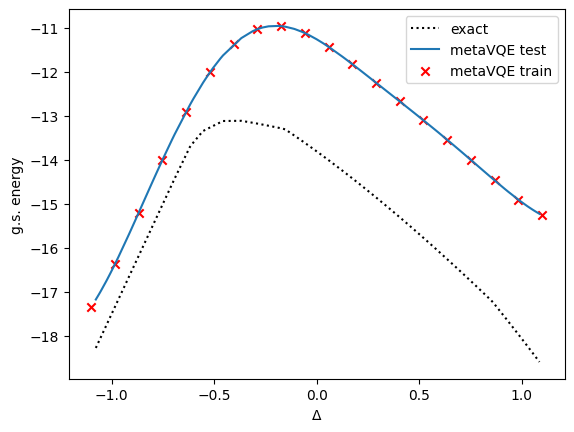

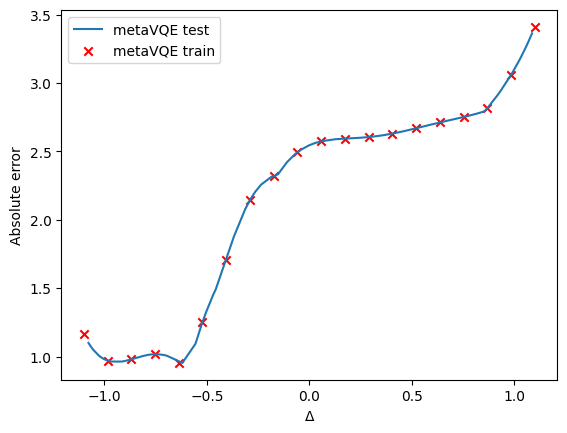

In [9]:
# PLOTS

# g.s. energy
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()
plt.show()

# Absolute error
plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()

### Comparison with other algorithms

#### Standard VQE

The first comparison test correponds with the well-known VQE algorithm. The standard VQE optimizes the values of the variables of the PQC for each Hamiltonian, i.e. for each value of $\Delta$. Then, in contrast with meta-VQE, we have to run individual optimizations for each Hamiltonian point instead of a single big optimization. 

The other main difference between VQE and meta-VQE is the encoding part of the circuit. Standard VQE algorithms do not encode the variables of the Hamiltonian into the PQC. Then, to compare with the above meta-VQE results, we fix the circuit depth, i.e. the total number of layers is the same, but all single-qubit rotations contain only two optimization variables (as if all layers were processing layers).

Due to the computational cost of running individual optimization for each value of $\Delta$, we compare meta-VQE and VQE algorithms using the equispaced training points generated for meta-VQE.

In [10]:
t0_VQE = time.time()

y_stVQE = []
error_stVQE = []

for i in range(n_train):
    ham = HXXZ(n_qub, arg_train[i], lamXXZ)

    # VQE circuit layers same as meta-VQE layers (encoding + variational parts)
    total_U = ans_var(n_qub, n_lay[0]+n_lay[1], 0, "th")

    Obj = tq.ExpectationValue(H=ham, U=total_U)

    variables = Obj.extract_variables()
    variables = sorted(variables, key=lambda x: x.name)

    # Random initialization of variables
    # new initialization because the circuit is different (no encoding part)
    th0_bis = {key: random.uniform(0, np.pi) for key in variables}

    initial_values = th0_bis
    standardVQE = tq.minimize(objective=Obj, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                              initial_values=initial_values, backend=backend, noise=None,
                              device=None, silent=True)
    res = standardVQE.energy
    # res_ex = Exact results same as meta-VQE training points

    # print(arg_train[i], y_train_ex[i], res, abs(res - y_train_ex[i]))

    y_stVQE.append(res)
    error_stVQE.append(abs(res-y_train_ex[i]))
    
t1_VQE = time.time()

#### Globally-averaged VQE (GA-VQE)

To check the power of the encoding strategy of the meta-VQE, we run a meta-VQE-like algorithm without encoding the Hamiltonian variables. We call this algorithm globally-averaged VQE, since it has the same PQC strucutre of a standard VQE but the optimization is done globally, by using the meta-VQE cost function defined above.

We use the same points used in the meta-VQE to train and test the GA-VQE.

In [11]:
# t0_GAVQE = time.time()

# Obj = tq.Objective()
# for i in range(n_train):
#     ham = HXXZ(n_qub, arg_train[i], lamXXZ)

#     # same number of layers as VQE and meta-VQE (encoding + variational parts)
#     total_U = ans_var(n_qub, n_lay[0] + n_lay[1], 0, "th")

#     Obj += tq.ExpectationValue(H=ham, U=total_U)

# # same variables as a starndard VQE, same random initiaization
# initial_values = th0_bis
# GA_VQE = tq.minimize(objective=Obj, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
#                             initial_values=initial_values, backend=backend, noise=None,
#                             device=None, silent=True)

# y_test_GAVQE = []
# error_test_GAVQE = []

# for i in range(n_test):
#     ham = HXXZ(n_qub, arg_test[i], lamXXZ)

#     # same number of layers as VQE and meta-VQE (encoding + variational parts)
#     total_U = ans_var(n_qub, n_lay[0] + n_lay[1], 0, "th")

#     exp_val = tq.ExpectationValue(H=ham, U=total_U)
#     res = tq.simulate(exp_val, variables=GA_VQE.angles)
#     # res_ex = same as meta-VQE test

#     # print(arg_test[i], y_test_ex[i], res, abs(res-y_test_ex[i]))

#     y_test_GAVQE.append(res)
#     error_test_GAVQE.append(abs(res-y_test_ex[i]))
    
# t1_GAVQE = time.time()

#### VQE with meta-VQE initialization (opt-meta-VQE)

Another potential advantage of running a meta-VQE algorithm is using the optimized variables of the later as initialization for the former. It is well known the barren plateau problem of PQC: if the minimization algorithm starts at a random point, both the gradient and variance of optimization variables tend to zero exponentially, leading a local minima result. There are several proposals to circunvent this problem. Ours is to start in a region close to the ground state solution by using the result of a meta-VQE as initialization point for a standard VQE (opt-meta-VQE).

Since the standard VQE do not contain encoding layers (with more optimization variables than the processing layers), we need to use a meta-VQE-like circuit to run the opt-meta-VQE (which uses the variables of the meta-VQE as starting point for the optimization). The use of encoding layes for a standard VQE had no sense, since the variables are initialized at random and, therefore, the two variables per rotational gate of the encoding layers can be redifined as a single variable. However, in this case, we are not starting at random but in a particular point suggested by the meta-VQE solution.

In [12]:
t0_optmetaVQE = time.time()

y_optmetaVQE = []
error_optmetaVQE = []

for i in range(n_train):
    ham = HXXZ(n_qub, arg_train[i], lamXXZ)

    # VQE with encoding layers (a meta-VQE PQC)
    total_U = ans_enc(n_qub, n_lay[0], arg_train[i], "th_en") + ans_var(n_qub, n_lay[1], 0, "th")

    Obj = tq.ExpectationValue(H=ham, U=total_U)

    # Initial values are the angles obtained after running the meta-VQE
    initial_values = metaVQE.angles

    optmetaVQE = tq.minimize(objective=Obj, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods,
                                           samples=None,
                                           initial_values=initial_values, backend=backend, noise=None, device=None,
                                           silent=True)
    res = optmetaVQE.energy
    # res_ex: Exact results same as meta-VQE training points

    # print(arg_train[i], y_train_ex[i], res, abs(res - y_train_ex[i]))

    y_optmetaVQE.append(res)
    error_optmetaVQE.append(abs(res - y_train_ex[i]))
    
t1_optmetaVQE = time.time()

#### VQE with GA-VQE initialization (opt-GA-VQE)

Finally, last test consist on using the result of the GA-VQE as the starting point for a standard VQE, similarly to the previous test. This time, the number of variables and the PQC is the same as the standard VQE (with no encoding layers).

In [13]:
# t0_optGAVQE = time.time()

# y_optGAVQE = []
# error_optGAVQE= []

# for i in range(n_train):
#     ham = HXXZ(n_qub, arg_train[i], lamXXZ)
        
#     # VQE number circuit layers same as meta-VQE layers (encoding + variational parts)
#     total_U = ans_var(n_qub, n_lay[0] + n_lay[1], 0, "th")

#     Obj = tq.ExpectationValue(H=ham, U=total_U)

#     # Initial values are the ones obtained in the GA-VQE optimization
#     initial_values = GA_VQE.angles

#     optGAVQE = tq.minimize(objective=Obj, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods,
#                                                  samples=None,
#                                                  initial_values=initial_values, backend=backend, noise=None,
#                                                  device=None, silent=True)
#     res = optGAVQE.energy
#     # res_ex: Exact results same as meta-VQE training points

#     #print(arg_train[i], y_train_ex[i], res, abs(res - y_train_ex[i]))

#     y_optGAVQE.append(res)
#     error_optGAVQE.append(abs(res - y_train_ex[i]))
    
# t1_optGAVQE = time.time()

### Plots

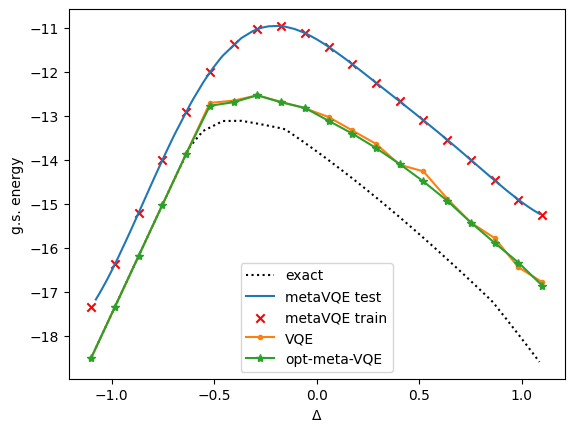

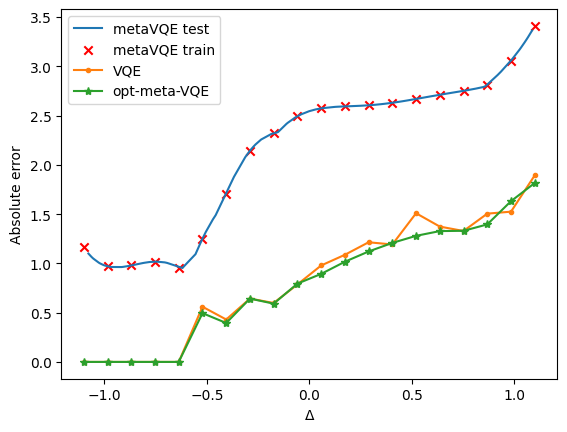

In [14]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_stVQE,  marker=".", label="VQE")
# plt.plot(x_test, y_test_GAVQE,  ls="--", label="GA-VQE")
plt.plot(x_train, y_optmetaVQE, marker="*", label="opt-meta-VQE")
# plt.plot(x_train, y_optGAVQE, marker="v", label="opt-GA-VQE")

plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()

plt.show()

# Absolute error

plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_stVQE, marker=".", label="VQE")
# plt.plot(x_test, error_test_GAVQE, ls="--", label="GA-VQE")
plt.plot(x_train, error_optmetaVQE, marker="*", label="opt-meta-VQE")
# plt.plot(x_train, error_optGAVQE, marker="v", label="opt-GA-VQE")

plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()